In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 67ms/step - loss: 0.0216 - val_loss: 3.8122e-04
Epoch 2/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0029 - val_loss: 4.7007e-04
Epoch 3/100
21/21 [==============================] - 1s 43ms/step - loss: 8.3431e-04 - val_loss: 9.0101e-05
Epoch 4/100
21/21 [==============================] - 1s 48ms/step - loss: 6.0295e-04 - val_loss: 8.5192e-05
Epoch 5/100
21/21 [==============================] - 1s 69ms/step - loss: 5.5921e-04 - val_loss: 8.0175e-05
Epoch 6/100
21/21 [==============================] - 1s 46ms/step - loss: 5.4324e-04 - val_loss: 7.4202e-05
Epoch 7/100
21/21 [==============================] - 1s 47ms/step - loss: 5.1655e-04 - val_loss: 7.1984e-05
Epoch 8/100
21/21 [==============================] - 1s 42ms/step - loss: 5.0364e-04 - val_loss: 7.0634e-05
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 4.8962e-04 - val_loss: 6.9505e-05
Epoch 10/100
21/21 [================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 18778.84032945315


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99840516128867
Testing MAE: 18772.935054774367


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.3294576406478882], [0.3322817385196686], [0.33497753739356995], [0.33758315443992615], [0.3401450216770172], [0.3426800072193146], [0.3451958894729614], [0.34769752621650696], [0.35018816590309143], [0.35267022252082825], [0.3551456034183502], [0.35761573910713196], [0.3600819408893585], [0.3625452220439911], [0.3650064766407013], [0.36746659874916077], [0.3699262738227844], [0.3723861873149872], [0.37484681606292725], [0.3773086965084076], [0.379772424697876], [0.3822380602359772], [0.38470619916915894], [0.38717716932296753], [0.38965120911598206], [0.3921284079551697], [0.39460909366607666], [0.39709341526031494], [0.3995814919471741], [0.4020734131336212], [0.4045693874359131], [0.4070693552494049], [0.40957334637641907], [0.41208142042160034], [0.4145936369895935], [0.41711002588272095], [0.4196304678916931], [0.42215496301651], [0.42468345165252686], [0.42721593379974365], [0.42975229024887085], [0.4322924315929413], [0.43483641743659973], [0.43738386034965515], [0.4399348497

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19920.9967142 ],
       [20033.99141174],
       [20141.8527509 ],
       [20246.10583398],
       [20348.60844782],
       [20450.03550085],
       [20550.69821411],
       [20650.7909517 ],
       [20750.44368713],
       [20849.75300626],
       [20948.79522381],
       [21047.62757584],
       [21146.30252873],
       [21244.86062468],
       [21343.33763622],
       [21441.76933589],
       [21540.1831493 ],
       [21638.60650204],
       [21737.05847281],
       [21835.56052513],
       [21934.13650734],
       [22032.7888043 ],
       [22131.54126434],
       [22230.40700406],
       [22329.39556282],
       [22428.51051785],
       [22527.76498576],
       [22627.16492864],
       [22726.71511615],
       [22826.41912555],
       [22926.28530376],
       [23026.31126595],
       [23126.49820453],
       [23226.84850435],
       [23327.36455023],
       [23428.04753459],
       [23528.89268777],
       [23629.90000976],
       [23731.06711572],
       [23832.39400567],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(156,)


(156, 1)

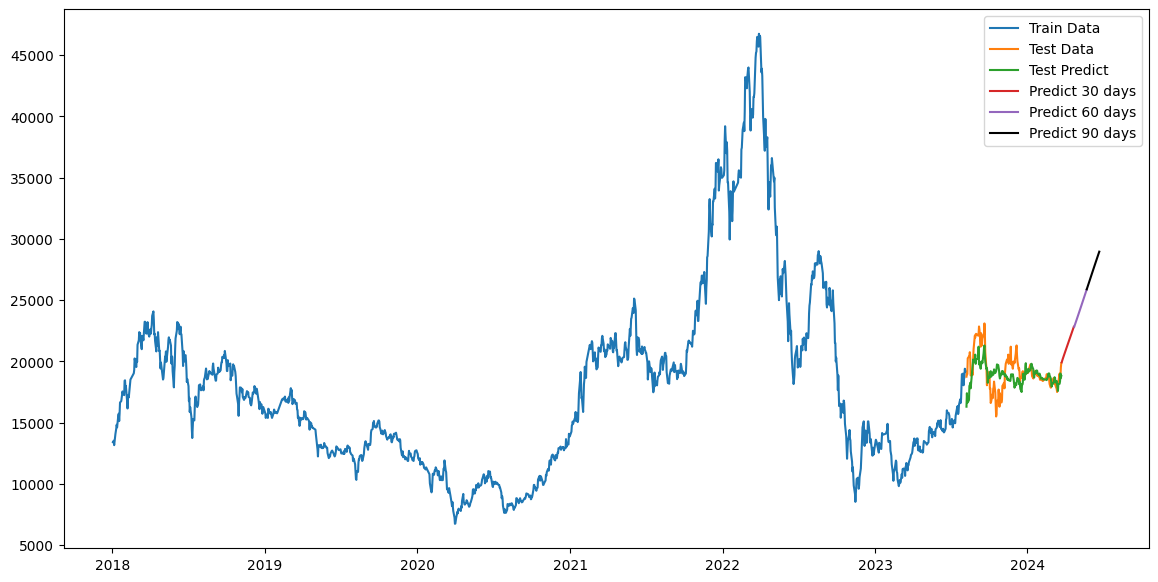

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()